In [2]:
!pip install textblob

     |████████████████████████████████| 636 kB 8.8 MB/s eta 0:00:01


In [4]:
import pandas as pd
# import wordcloud
# from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sklearn.metrics as metrics
from sklearn.metrics import plot_confusion_matrix

In [5]:
dataset = pd.read_csv('../input_data/train_clean_4.csv')

In [7]:
columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'total_toxic']

In [8]:
dataset['total_toxic'] = 0
dataset.loc[dataset['toxic'] + dataset['severe_toxic'] + dataset['obscene'] + dataset['threat'] 
            + dataset['insult'] + dataset['identity_hate'] > 0, 'total_toxic'] = 1

In [9]:
for col in columns:
    print('The percentage of', col, 'comments is', round(dataset[col].sum() / dataset.shape[0] * 100, 2), '%')

The percentage of toxic comments is 9.15 %
The percentage of severe_toxic comments is 1.07 %
The percentage of obscene comments is 5.33 %
The percentage of threat comments is 0.25 %
The percentage of insult comments is 4.91 %
The percentage of identity_hate comments is 0.99 %
The percentage of total_toxic comments is 9.85 %


In [7]:
print("Average length of comments", dataset['comment_text'].str.len().mean())
print("Average length of toxic comments", dataset[dataset['label']==1]['comment_text'].str.len().mean())
print("Average length of non toxic comments", dataset[dataset['label']==0]['comment_text'].str.len().mean())

Average length of comments 352.5095143040021
Average length of toxic comments 179.85384719772017
Average length of non toxic comments 395.635683246446


In [8]:
dataset['sentiment'] = dataset['comment_text'].apply(lambda x:TextBlob(x).sentiment.polarity)    

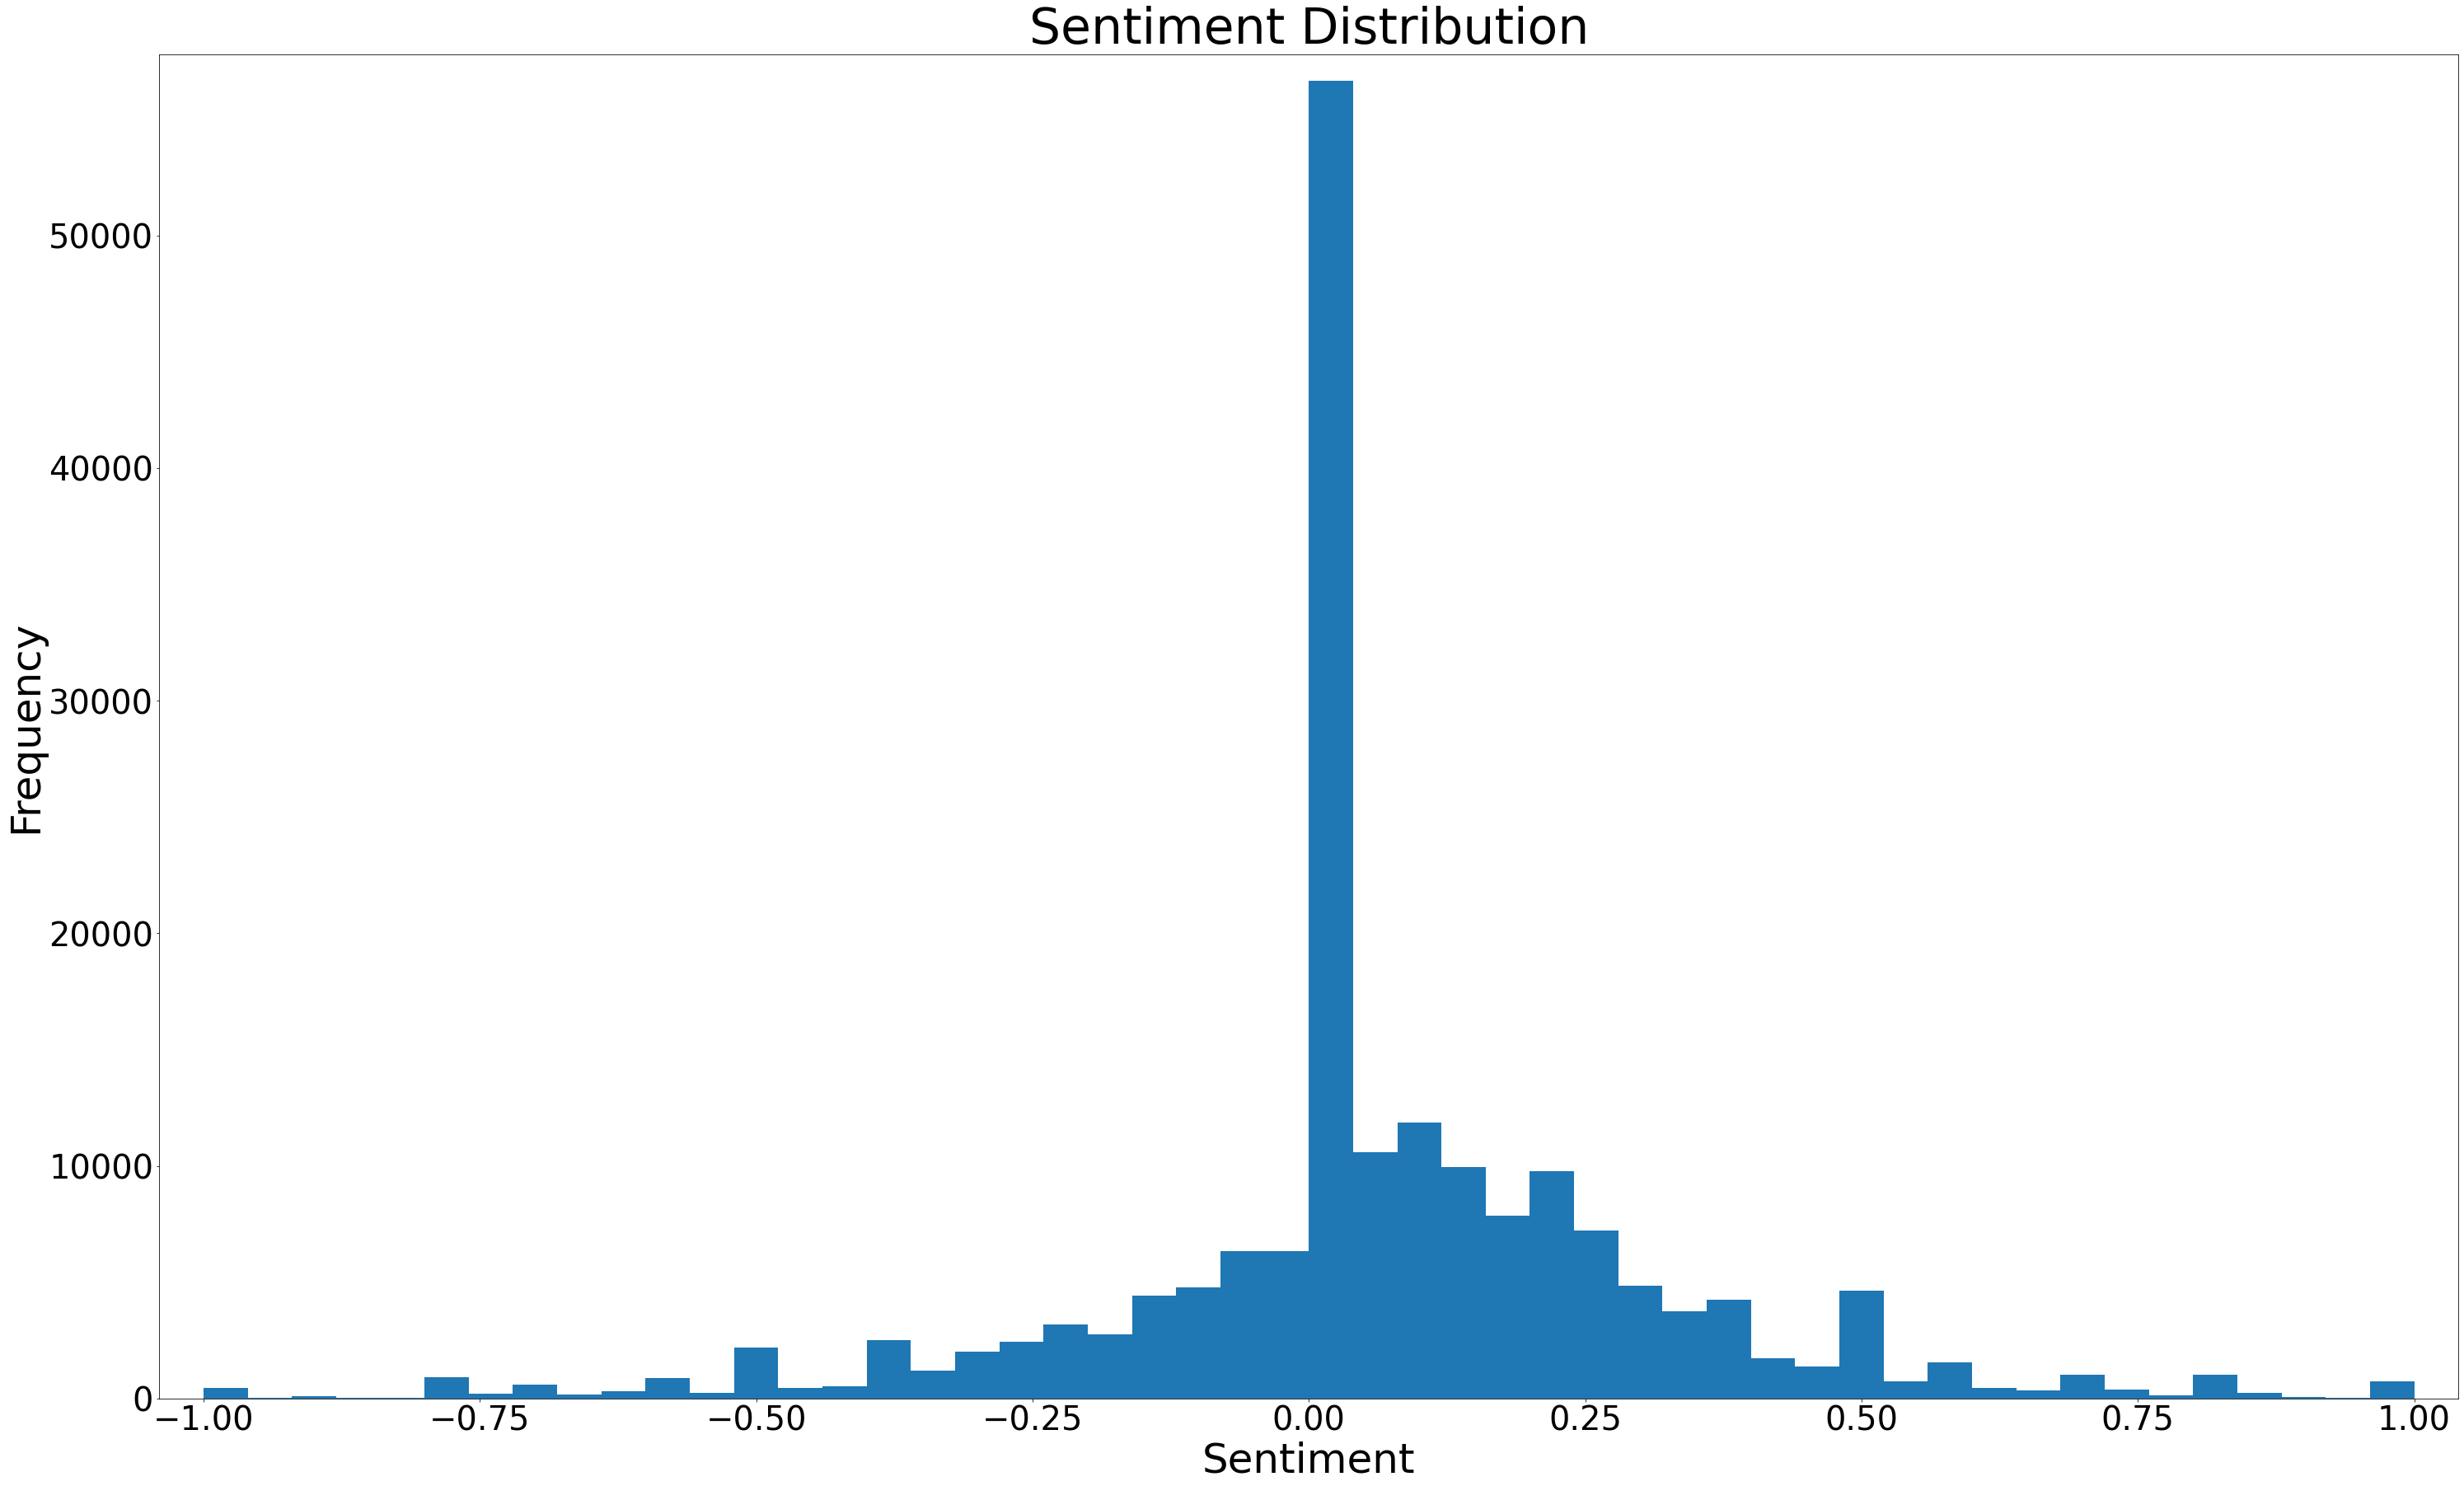

In [25]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(dataset['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.savefig('../plots/sentiment_dist.png')
plt.show()

In [18]:
! pip install wordcloud

  Using cached wordcloud-1.8.1.tar.gz (220 kB)
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp39-cp39-macosx_10_9_x86_64.whl size=154071 sha256=1abf6b6c54166049bd3a4d29f3747afaa8c56d1018dabee2a65e857d7e51ad0f
  Stored in directory: /Users/gonzalosanhueza/Library/Caches/pip/wheels/f9/7a/dd/06ef8b5dfe5483f6204133c08eeb16c287cc2c05e290ae2fc0
Successfully built wordcloud


In [26]:
from wordcloud import WordCloud

def word_cloud(df, column_name, toxic):
    this_star_text = ''
    for t in df[df[column_name] == toxic]['comment_text'].values: # form field cell
        this_star_text += t + ' '
    
    wordcloud = WordCloud() 
    wordcloud.generate_from_text(this_star_text)
    plt.figure(figsize=(14,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.savefig('../plots/word_cloud_' + str(toxic) + '.png')

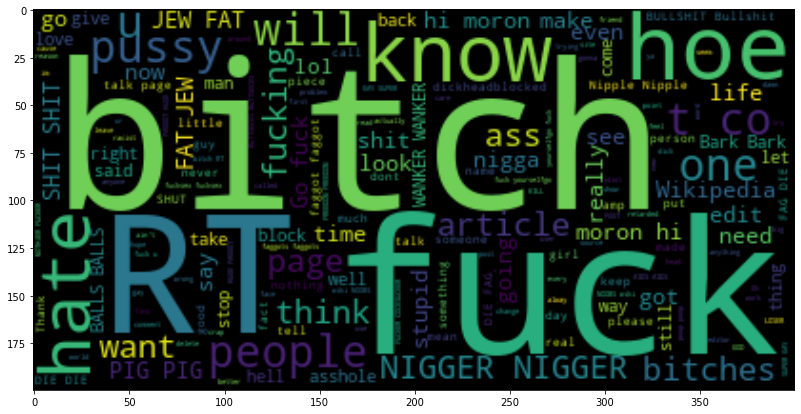

In [27]:
word_cloud(dataset, 'label', 1)

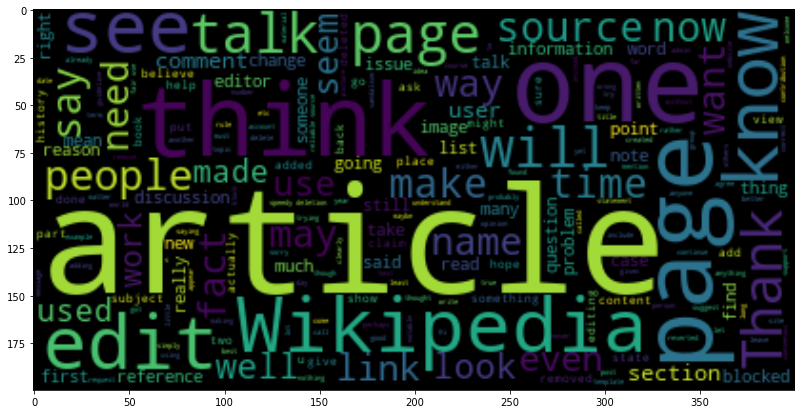

In [28]:
word_cloud(dataset, 'label', 0)

### Logistic Regressiondataset = pd.read_csv("../data/sample_data.csv")

In [13]:
# load data
sample_dataset = pd.read_csv("../input_data/sample_data.csv")

In [39]:
# clean data
sample_dataset['total_toxic'] = 0
sample_dataset.loc[sample_dataset['toxic'] + sample_dataset['severe_toxic'] + sample_dataset['obscene'] + sample_dataset['threat'] 
            + sample_dataset['insult'] + sample_dataset['identity_hate'] > 0, 'total_toxic'] = 1
sample_dataset["clean_text"] = sample_dataset.comment_text.apply(preprocessing.clean_text)

KeyboardInterrupt: 

In [49]:
sample_dataset.loc[sample_dataset.total_toxic == 1, "comment_text"]

18      I shall do as I please you dirty double nigger...
41      Sorry??? i was commenting on the page, you blo...
62                  THE MOST ANNOYING FUCKING IDIOT EVER.
110     user:jeppiz and user:DeCausa are busy in moles...
125     your uncivil threats \n\nYour uncivil threats ...
                              ...                        
9969    How about you learn how to read and write duri...
9973    Stop harassing me! \n\nSeriously, stop harassi...
9978               Anonymous \n\nYou gay Afambro fuck you
9985    Fuck You wikipedia. the edits i did we're real...
9996    if they dont score a milliuon goals for vinnie...
Name: comment_text, Length: 985, dtype: object

In [18]:
# split into trian and test data
train, test = train_test_split(sample_dataset, test_size=0.2, random_state=23)
train_text = train.comment_text.tolist()
test_text = test.comment_text.tolist()
train_labels = train.total_toxic
test_labels = test.total_toxic

In [91]:
# preprocess into tf-idf
vec = TfidfVectorizer(stop_words="english", ngram_range=(1, 1), use_idf=True) # use_idf allows idf reweighting
train_tfIdf = vec.fit_transform(train_text)
test_tfIdf = vec.transform(test_text)

In [108]:
# show example of tf-idf
idx_example = 16
print(train.iloc[idx_example].comment_text)
df = pd.DataFrame(train_tfIdf[idx_example].T.todense(), index=vec.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print(df.loc[df['TF-IDF'] > 0])

Thanks for the welcome
Just to let you know that it is a cat and mouse game between Brahmos and BrahMos. Will be more subtle next time.
           TF-IDF
brahmos  0.734918
mouse    0.324024
subtle   0.312650
cat      0.266050
game     0.225234
welcome  0.181261
let      0.176565
thanks   0.144258
time     0.138484
know     0.132658
just     0.118421


In [20]:
# create logistic model
logit = LogisticRegression(C=5e1, random_state=23, n_jobs=-1)
logit.fit(train_tfIdf, train_labels)
test["prob_toxic"] = logit.predict_proba(test_tfIdf)[:,1]
test["pred_toxic"] = logit.predict(test_tfIdf)

out_df = test[["id", "comment_text", "total_toxic", "prob_toxic", "pred_toxic"]]
print((out_df.pred_toxic == out_df.total_toxic).mean())
print(out_df.loc[out_df.pred_toxic == out_df.total_toxic, ["comment_text", "total_toxic"]])
print(out_df.total_toxic.mean())

0.9525
                                           comment_text  total_toxic
6326  One more time I am asking everybody to concent...            0
5185  "\n\n""It is clearly designed to denigrate tho...            0
2495  " - "" Basically, acting today has boiled down...            0
2765  "\n\n Unclear Statement \n\nThe use of the phr...            0
9303  "\n\n ""List of vehicles in The Simpsons"" cur...            0
...                                                 ...          ...
9392  December 2008\n Please stop. If you continue t...            0
5640  Thank you for your kind words.\nI never said y...            0
8667  I will travel for some days, perhaps ask Yngva...            0
6027  Please refrain from adding nonsense to Wikiped...            0
9764  "\n\n"" if you're going to take it as an insul...            0

[1905 rows x 2 columns]
0.092


In [89]:
# example text cleansing

original_text = "They are st.upid and ig.norant with no class"
print(f"Original text: \n{original_text}")

# standard method
standard_clean = logit.predict_proba(vec.transform([original_text]))[:,1]
print(f"Standard cleaning probability of toxic: {round(standard_clean[0], 3)}\n")

# our method
clean_text = preprocessing.clean_text(original_text)
print(f"Cleaned text: \n{clean_text}")
our_clean = logit.predict_proba(vec.transform([clean_text]))[:,1]
print(f"Our preprocessing probability of toxic: {round(our_clean[0], 3)}")

Original text: 
They are st.upid and ig.norant with no class
Standard cleaning probability of toxic: 0.007

Cleaned text: 
they are stupid and ignorant with no class
Our preprocessing probability of toxic: 0.999


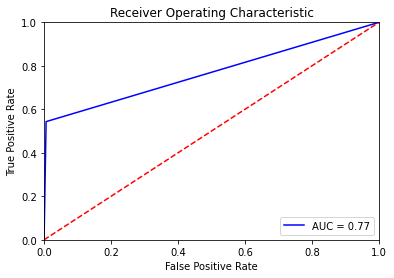

In [24]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(out_df.total_toxic, out_df.pred_toxic)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



In [25]:
out_df.head()

,id,comment_text,total_toxic,prob_toxic,pred_toxic
6326,fcec7511d6cd20af,One more time I am asking everybody to concent...,0,0.000127,0
5185,1d94a6020f3f5eb0,"""\n\n""""It is clearly designed to denigrate tho...",0,0.048035,0
2495,1d01790a0f25b76d,""" - """" Basically, acting today has boiled down...",0,0.041638,0
2765,04f3066d3bf6bf37,"""\n\n Unclear Statement \n\nThe use of the phr...",0,0.009788,0
9303,41fc97dd1f693c3f,"""\n\n """"List of vehicles in The Simpsons"""" cur...",0,0.001659,0


In [26]:
cm = confusion_matrix(out_df.total_toxic, out_df.pred_toxic)  

In [27]:
print("Accuracy: ", metrics.accuracy_score(out_df.total_toxic, out_df.pred_toxic))
print("Precision: ", metrics.precision_score(out_df.total_toxic, out_df.pred_toxic))
print("Recall: ", metrics.recall_score(out_df.total_toxic, out_df.pred_toxic))

Accuracy:  0.9525
Precision:  0.9009009009009009
Recall:  0.5434782608695652


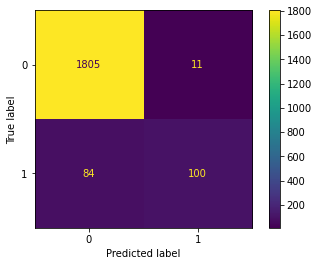

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logit.classes_)
disp.plot()
plt.show()